In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
from teren.dir_act_utils import *

SEED = 0
LAYER = 0
SEQ_LEN = 32
INFERENCE_TOKENS = 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")
# TODO
N_PROMPTS = INFERENCE_BATCH_SIZE * 5

INFERENCE_BATCH_SIZE=400


In [3]:
from teren import utils as teren_utils

device = teren_utils.get_device_str()
print(f"{device=}")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)
d_model = model.cfg.d_model
input_ids = get_input_ids(chunk=0, seq_len=SEQ_LEN)[:N_PROMPTS]

device='cuda'
Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
resid_acts = get_clean_resid_acts(model, LAYER, input_ids, INFERENCE_BATCH_SIZE)

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
torch.manual_seed(SEED)
dir = torch.randn(d_model)
dir = dir / dir.norm()

In [6]:
dir_acts = compute_dir_acts(dir, resid_acts)
acts_range = get_act_range(dir_acts, q_min=0.03, q_max=0.97)

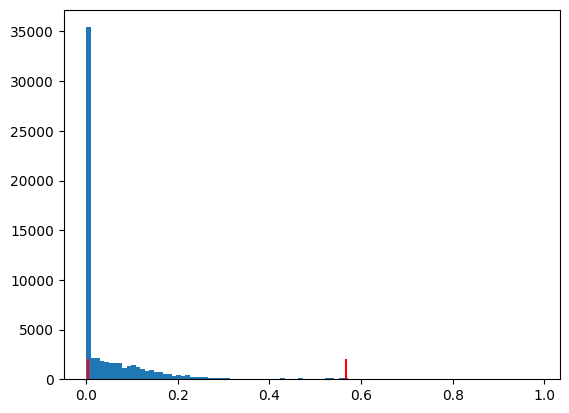

In [7]:
import matplotlib.pyplot as plt

plt.hist(dir_acts.flatten(), bins=100)
plt.vlines(acts_range, 0, 2000, colors="r")  # type: ignore
plt.show()

In [8]:
abl_resid_acts = ablate_dir(resid_acts, dir, dir_acts)

In [9]:
comp_js_divergence(
    torch.tensor([[5.0] + [0] * 10, [5.0] + [0] * 10]),
    torch.tensor([[5.0] + [0] * 10, [0] * 10 + [5.0]]),
)

tensor([5.1042e-08, 8.8851e-01])

In [10]:
pert_resid_acts = compute_pert_resid_acts(
    abl_resid_acts=abl_resid_acts,
    act_values=torch.tensor(acts_range),
    dir=dir,
)

In [11]:
pert_resid_acts.shape

torch.Size([2, 2000, 32, 768])

In [12]:
jsd = comp_model_js_div(
    model,
    LAYER,
    resid_acts_a=pert_resid_acts[0],
    resid_acts_b=pert_resid_acts[1],
    batch_size=INFERENCE_BATCH_SIZE // 2,
)

  0%|          | 0/10 [00:00<?, ?it/s]

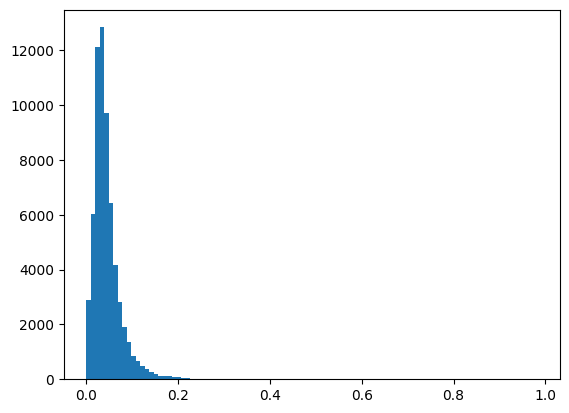

In [19]:
plt.hist(jsd.sqrt().flatten(), 100)

In [20]:
def dir_to_hist(model, layer, dir, resid_acts, batch_size):
    dir_acts = compute_dir_acts(dir, resid_acts)
    acts_range = get_act_range(dir_acts, q_min=0.03, q_max=0.97)
    abl_resid_acts = ablate_dir(resid_acts, dir, dir_acts)
    pert_resid_acts = compute_pert_resid_acts(
        abl_resid_acts=abl_resid_acts,
        act_values=torch.tensor(acts_range),
        dir=dir,
    )
    pert_resid_acts_min, pert_resid_acts_max = pert_resid_acts
    js_dist = comp_model_js_div(
        model,
        layer,
        pert_resid_acts_min,
        pert_resid_acts_max,
        batch_size=batch_size // 2,
    ).sqrt()
    counts, _edges = torch.histogram(js_dist, bins=100, range=(0, 1))
    return counts

In [24]:
counts = dir_to_hist(model, LAYER, dir, resid_acts, INFERENCE_BATCH_SIZE)

  0%|          | 0/10 [00:00<?, ?it/s]

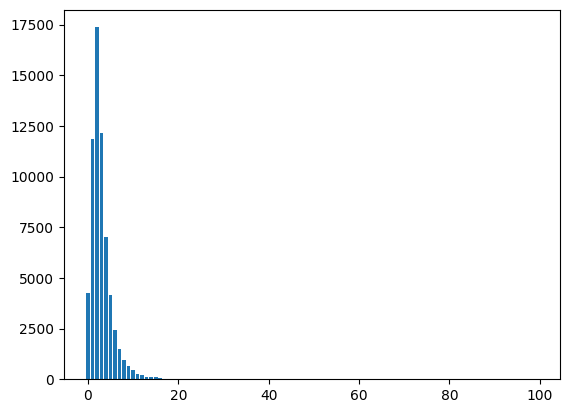

In [28]:
plt.bar(torch.arange(100), counts)